In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Lambda,Compose,Resize,Normalize
import matplotlib.pyplot as plt
from functools import reduce
from models.equivariant import *
from groupconv.groups import *
from utils.train import count_params, train,val
from data.loader import get_loader
import os

In [2]:
torch.manual_seed(1)

In [3]:
BS=1
EPOCHS=15
NCLASSES = 10
NAME = "C4SimpleCNN_FashionMNIST"

Get a random sample from the testset

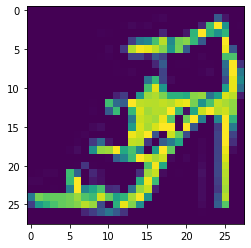

True label:tensor([5])


In [4]:
testloader = get_loader("test",BS,NCLASSES)
it = iter(testloader)
x,y = next(it)
plt.imshow(x[0,0,:,:])
plt.show()
label = torch.argmax(y,dim=-1)
print(f"True label:{label}")

Now we do the same plots but the second sample is no more a rotation of the first sample but it is a sample from a different class

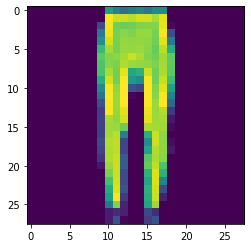

In [5]:
x_hat,y_hat = next(it)
plt.imshow(x_hat[0,0,:,:])
plt.show()

Instantiate the Group Equivariant Convolutional Network trained on the dataset without augmentation

In [6]:
m = EqSimpleCNN(CyclicGroup(4),4,NCLASSES)
m.eval()
print(m)

EqSimpleCNN(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): CyclicGroup()
    )
  )
  (r1): ReLU()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r2): ReLU()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


/home/giorgio/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
ret = m.load_state_dict(torch.load(f"ckpt/{NAME}.pth"))
ret

<All keys matched successfully>

Compute the feature maps for all intermediate layers for both the sample both for the 0 rotation and the 90 degree rotation

In [8]:
oc1 = m.c1(x)
or1 = m.r1(oc1)
op1 = m.p1(or1)
oc2 = m.c2(op1)
or2 = m.r2(oc2)
op2 = m.p2(or2)
oc3 = m.c3(op2)
or3 = m.r3(oc3)
ogp = m.gp(or3)
ogrp = m.group_pooling(ogp)
oclf = m.clf(ogrp)

In [9]:
oc1_hat = m.c1(x_hat)
or1_hat = m.r1(oc1_hat)
op1_hat = m.p1(or1_hat)
oc2_hat = m.c2(op1_hat)
or2_hat = m.r2(oc2_hat)
op2_hat = m.p2(or2_hat)
oc3_hat = m.c3(op2_hat)
or3_hat = m.r3(oc3_hat)
ogp_hat = m.gp(or3_hat)
ogrp_hat = m.group_pooling(ogp_hat)
oclf_hat = m.clf(ogrp_hat)

In [10]:
feature_maps = [oc1,or1,op1,oc2,or2,op2,oc3,or3,ogp,ogrp,oclf]
feature_maps_hat = [oc1_hat,or1_hat,op1_hat,oc2_hat,or2_hat,op2_hat,oc3_hat,or3_hat,ogp_hat,ogrp_hat,oclf_hat]

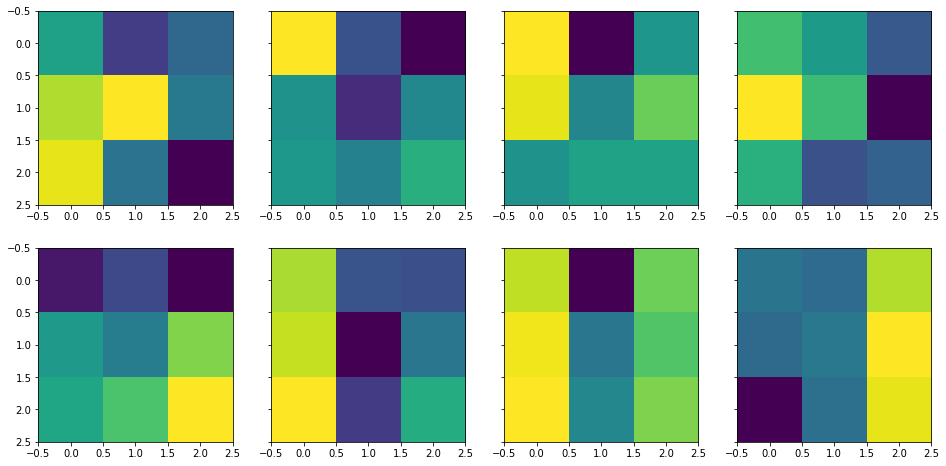

In [11]:
layer_idx = 3 # 0 - 8
filter_idx = 2
fig,ax = plt.subplots(2,4,sharey=True)
fig.set_size_inches(16,8)
for g in range(4):
    f = feature_maps[layer_idx][0,filter_idx,g,...]
    f_hat = feature_maps_hat[layer_idx][0,filter_idx,g,...]
    if len(f.shape)<2:
        ax[0,g].scatter(0,f.detach().numpy())
        ax[1,g].scatter(0,f_hat.detach().numpy())
    else:
        ax[0,g].imshow(f.detach().numpy())
        ax[1,g].imshow(f_hat.detach().numpy())
plt.show()

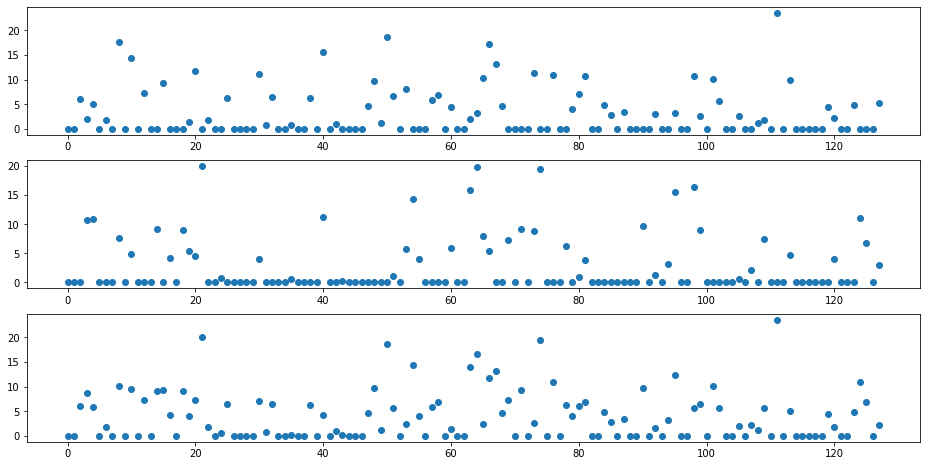

In [12]:
fig,ax = plt.subplots(3,1,sharey=False)
fig.set_size_inches(16,8)
ax[0].scatter(np.arange(128),ogrp[0].detach().numpy())
ax[1].scatter(np.arange(128),ogrp_hat[0].detach().numpy())
ax[2].scatter(np.arange(128),torch.abs(ogrp[0]-ogrp_hat[0]).detach().numpy())
plt.show()